# Train

In [1]:
import numpy as np
import torch
import os
import torchvision.transforms as transforms
import random
import torchvision.models as models
import json
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")

print(f'The device is: {device}')

The device is: cpu


In [3]:
data_path = './'
BATCH_SIZE = 32
size = 128 #size of the picture pixels
train_size = 0.8 #train data size
val_size = 1 - train_size #validation data size
NUM_EPOCHS = 10 #number of epochs
learning_rate = 0.01

classLossFunc = torch.nn.CrossEntropyLoss() #classification output loss
bboxLossFunc = torch.nn.MSELoss() #bounding box regression output loss


# Let see the folder structure

In [4]:
data_list = os.listdir(data_path)
folders = []
data_names = []
num = 1
for i in data_list:
    if os.path.isdir(os.path.join(data_path,i)) == True and 'check' not in i:
        folders.append(os.path.join(data_path, i))
        data_names.append(i)
        print(f'The {num} folder name is: {i}')
        num+=1

The 1 folder name is: Araneae
The 2 folder name is: Coleoptera
The 3 folder name is: Diptera
The 4 folder name is: Hemiptera
The 5 folder name is: Hymenoptera
The 6 folder name is: Lepidoptera
The 7 folder name is: Odonata


In [5]:
data_names

['Araneae',
 'Coleoptera',
 'Diptera',
 'Hemiptera',
 'Hymenoptera',
 'Lepidoptera',
 'Odonata']

In [6]:
folders[:5]

['./Araneae', './Coleoptera', './Diptera', './Hemiptera', './Hymenoptera']

In [7]:
labels_dict = {}
num = 0
for label in data_names:
    if os.path.isdir(os.path.join(data_path,label)) == True:
        labels_dict[label] = num
        num+=1

Now we have a label dictionary, to compute the loss. 

In [8]:
print(f'The keys in a labels dictionary is: {[i for i in labels_dict]}')

The keys in a labels dictionary is: ['Araneae', 'Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Odonata']


# Open annotations

This few rows a test, how to open the annotation file

In [9]:
for i in os.listdir(folders[0]):
    if os.path.isdir(os.path.join(folders[0],i))==True:
        print(f'In folder I found folder(s):{i}')

In folder I found folder(s):annotations


In [10]:
annotations_0 = os.listdir(os.path.join(folders[0], 'annotations'))

In [11]:
for i in range(len(annotations_0)):
    data = json.load(open(os.path.join(folders[0], 'annotations', annotations_0[i])))
    try:
        a = data['asset']
    except KeyError:
        print(f'in In file on this index --> {i}  no have asset data.')
    

in In file on this index --> 1674  no have asset data.


In [12]:
data = json.load(open(os.path.join(folders[0], 'annotations', annotations_0[5])))

In [13]:
data

{'asset': {'format': 'jpg',
  'id': '008d2c8cbdc662d81f0042c1125beecf',
  'name': 'fcb145eae10a.jpg',
  'path': 'file:F:/ArTaxOr/Araneae/fcb145eae10a.jpg',
  'size': {'width': 1161, 'height': 1741},
  'state': 2,
  'type': 1},
 'regions': [{'id': 'rk9F4J3H7',
   'type': 'RECTANGLE',
   'tags': ['Araneae'],
   'boundingBox': {'height': 1435.8247126436781,
    'width': 835.7198275862069,
    'left': 121.95400053879311,
    'top': 98.38984674329502},
   'points': [{'x': 121.95400053879311, 'y': 98.38984674329502},
    {'x': 957.673828125, 'y': 98.38984674329502},
    {'x': 957.673828125, 'y': 1534.2145593869732},
    {'x': 121.95400053879311, 'y': 1534.2145593869732}]}],
 'version': '2.1.0'}

In [14]:
filename = data['asset']['path']

In [15]:
filename

'file:F:/ArTaxOr/Araneae/fcb145eae10a.jpg'

In [16]:
box = data['regions'][0]['boundingBox']  
box

{'height': 1435.8247126436781,
 'width': 835.7198275862069,
 'left': 121.95400053879311,
 'top': 98.38984674329502}

In [17]:
data['regions'][0]['tags'][0]

'Araneae'

# Open the pictures

In [18]:
file = filename.split('file:F:/ArTaxOr/') # need to split all filename
print(f'The file path is: {file[1]}')

The file path is: Araneae/fcb145eae10a.jpg


[]

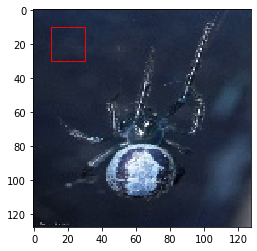

In [19]:
image = cv2.imread(os.path.join(data_path, file[1]))
fig, ax = plt.subplots()
rect = patches.Rectangle((10, 10), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
ax.imshow(image)
ax.add_patch(rect)
plt.plot()

# Making the data class

In [20]:
class DataImgBox(Dataset):
    def __init__(self, data_dir, width, height, labels_dict, size):
        self.data_dir = data_dir
        self.width = width
        self.height = height
        self.annot_list = []
        self.labels_dict = labels_dict
        self.size = size 
        
        self.data_names = os.listdir(self.data_dir)
        self.folders = []
        for i in self.data_names:
            if os.path.isdir(os.path.join(self.data_dir,i)) == True:
                self.folders.append(os.path.join(self.data_dir, i))
                
        for j in range(len(self.folders)):        
            for i in os.listdir(self.folders[j]):
                if os.path.isdir(os.path.join(self.folders[j],i))==True:
                    for annot in os.listdir(os.path.join(self.folders[j],i)):
                        if '.json' in annot:
                            self.annot_list.append(os.path.join(self.folders[j],i,annot))
        
        random.shuffle(self.annot_list) 
        self.annot_list = self.annot_list[:round((len(self.annot_list)*self.size))]
        self.len = len(self.annot_list)
        
                        
    def __len__(self):
        return self.len 
    
        
    def __getitem__(self,idx):
        data = json.load(open(self.annot_list[idx]))
        filename = data['asset']['path']
        box = data['regions'][0]['boundingBox'] 
        label = data['regions'][0]['tags'][0]
        height = data['asset']['size']['height']
        width = data['asset']['size']['width']
        
        filename = filename.split('file:F:/ArTaxOr/')
        filename = os.path.join(self.data_dir, filename[1])
        
        image = cv2.imread(filename)
        #image = Image.open(filename)
        #image = image / 255
        #transform = transforms.Compose([transforms.Resize((self.width, self.height)), transforms.ToTensor()])
        transform = transforms.Compose([
                                        transforms.ToTensor()
                                        ])
        resized_img = transform(image)
                
        self.scale_x =  width/self.width
        self.scale_y = height/self.height
        
        x = round(box['left']/self.scale_x)
        y = round(box['top']/self.scale_y)
        new_width = round(box['width']/self.scale_x)
        new_height = round(box['height']/self.scale_y)
        
        bbox = np.array([x, y, new_width, new_height])
        
        return resized_img, torch.tensor(bbox), torch.tensor(self.labels_dict[label])

In [21]:
def show_data(data_sample, BOX, LABEL, pred_box=None, train = True):
    
    fig, ax = plt.subplots()
    bbox = patches.Rectangle((BOX[0], BOX[1]), BOX[2], BOX[3], linewidth=1, edgecolor='r', facecolor='none')
    x.imshow(data_sample[1].numpy(),  interpolation='nearest')
    ax.add_patch(bbox)
    print(f'True box: {BOX}')
    print(LABEL)
    if not train :
        
       # fig, ax = plt.subplots()
       # bbox = patches.Rectangle((BOX[0], BOX[1]), BOX[2], BOX[3], linewidth=1, edgecolor='r', facecolor='none')
        bbox_pred = patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3], linewidth=1, edgecolor='b', facecolor='none')
        ax.imshow(data_sample[1].numpy())
        #ax.add_patch(bbox)
        ax.add_patch(bbox_pred)
        #print(f'True box: {BOX}')
        print(f'Predicted box: {pred_box}')
        #print(LABEL)
        

# Neural net class

pretrained model ResNet

In [22]:
class _(self):
    Network_resnet(torch.nn.Module):
        super(Network_resnet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        
        layers = list(resnet.children())[:8]
        self.features1 = torch.nn.Sequential(*layers[:6])
        self.features2 = torch.nn.Sequential(*layers[6:])
       
        self.classifier = torch.nn.Sequential(torch.nn.BatchNorm1d(512),   torch.nn.Linear(512, 256),
                                              torch.nn.ReLU(),  torch.nn.Linear(256, 7))
        self.bb = torch.nn.Sequential(torch.nn.BatchNorm1d(512),torch.nn.Linear(512, 128), 
                                      torch.nn.ReLU(), torch.nn.Linear(128, 4))
       
     def forward(self, x):
    def __init_
        x = self.features1(x)
        x = self.features2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)  
        classific = self.classifier(x)      
        regression = self.bb(x)
        return classific, regression

Pretrained model VGG

In [23]:
#model = models.vgg16(pretrained = True)

In [24]:
class Network_vgg(torch.nn.Module):
    def __init__(self):
        super(Network_vgg, self).__init__()
        
        self.fc = torch.nn.Linear(25088, 128)
        self.fc1 = torch.nn.Linear(128, 32)
        
        self.classif = torch.nn.Linear(32, 7)
        
        self.bbox = torch.nn.Linear(32, 4)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1) 
        x = torch.nn.functional.relu(self.fc(x))
        
        # classification
        a = torch.nn.functional.relu(self.fc1(x))
        classification = self.classif(a)
        
        # regression
        b = torch.nn.functional.relu(self.fc1(x))
        regression = self.bbox(b)
        
        return classification, regression      

In [25]:
#model.classifier = Network()

Custom model

In [26]:
kernel = 3
padding = 1
stride = 1
stride_max = 2

In [27]:
# Computing the first fully connected layers input.

# CONV = (W − K + 2*P)/S + 1
# MAXPOOL = (W - K)/S + 1
out1 = (128 - kernel + 2 * padding)/stride + 1
maxpool = (out1 - kernel)/stride_max + 1
out2 = (maxpool - kernel + 2 * padding)/stride + 1
maxpool2 = (out2 - kernel)/stride_max + 1
out3 = (maxpool2 - kernel + 2 * padding)/stride + 1
maxpool3 = (out3 - kernel)/stride_max + 1
out4 = (maxpool3 - kernel + 2 * padding)/stride + 1
maxpool4 = (out4 - kernel)/stride_max + 1
out5 = (maxpool4 - kernel + 2 * padding)/stride + 1
maxpool5 = int((out5 - kernel)/stride_max + 1)

print(maxpool5)

3


In [28]:
class Net(torch.nn.Module):   
    def __init__(self):
        super(Net, self).__init__()
        
        self.dropout = torch.nn.Dropout(0.25)
        
        self.cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layers
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        

        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(256 * 4 * 4, 128))
        
        self.classifier = torch.nn.Sequential(#torch.nn.BatchNorm1d(128),
                                              torch.nn.ReLU(inplace=True),
                                              torch.nn.Dropout(0.2),
                                              torch.nn.Linear(128, 64),
                                              torch.nn.ReLU(inplace=True),
                                              torch.nn.Dropout(0.2),
                                              torch.nn.Linear(64, 7),
                                              torch.nn.Softmax(dim=1))
  
        
        self.bb = torch.nn.Sequential(torch.nn.BatchNorm1d(128),
                                      torch.nn.ReLU(inplace=True),
                                      torch.nn.Dropout(0.2),
                                      torch.nn.Linear(128, 64),
                                      torch.nn.ReLU(inplace=True),
                                      torch.nn.Dropout(0.2),
                                      torch.nn.Linear(64, 4))
       

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        
        return self.classifier1(x), self.bb(x)

In [29]:
class Net_1(torch.nn.Module):   
    def __init__(self):
        super(Net_1, self).__init__()
        
        self.dropout = torch.nn.Dropout(0.25)
        
        self.cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(3, 16, kernel_size=kernel, stride=stride, padding=padding),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=kernel, stride=stride_max),
            
            torch.nn.Conv2d(16, 32,  kernel_size=kernel, stride=stride, padding=padding),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=kernel, stride=stride_max),
            
            torch.nn.Conv2d(32, 64,  kernel_size=kernel, stride=stride, padding=padding),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=kernel, stride=stride_max),
        
            torch.nn.Conv2d(64, 128,  kernel_size=kernel, stride=stride, padding=padding),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=kernel, stride=stride_max),
            
            torch.nn.Conv2d(128, 256, kernel_size=kernel, stride=stride, padding=padding),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=kernel, stride=stride_max))
        

        self.linear_layers = torch.nn.Sequential(
                                                torch.nn.Linear(256 * maxpool5**2, 128),
                                                torch.nn.ReLU(inplace=True),
                                                torch.nn.Dropout(0.3),
                                                torch.nn.Linear(128, 64),
                                                torch.nn.BatchNorm1d(64),
                                                torch.nn.ReLU(inplace=True),
                                                torch.nn.Dropout(0.3))
        
        self.classifier = torch.nn.Sequential(torch.nn.Linear(64, 32),
                                              torch.nn.BatchNorm1d(32),
                                              torch.nn.ReLU(inplace=True),
                                              torch.nn.Dropout(0.2),
                                              torch.nn.Linear(32, 7))
                                            
  
        
        self.bb = torch.nn.Sequential(
                                    torch.nn.Linear(64, 32),
                                    torch.nn.BatchNorm1d(32),
                                    torch.nn.ReLU(inplace=True),
                                    torch.nn.Dropout(0.2),
                                    torch.nn.Linear(32, 4))
       

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        
        return self.classifier(x), self.bb(x)

In [30]:
model_net1= Net_1().to(device)

In [31]:
model_resnet = Network_resnet().to(device)

# Train and validation loaders 

In [32]:
train = DataImgBox(data_path, size, size, labels_dict, train_size)
val = DataImgBox(data_path, size, size, labels_dict, val_size)

In [33]:
print(f'The lenght of the train set is: {len(train)}.\nThe lenght of the validation set is: {len(val)}')

The lenght of the train set is: 12300.
The lenght of the validation set is: 3075


The output is only 1 train example:

In [34]:
pic,box,label =  train[0]

In [35]:
print(f'The first output is the picture tensor: {pic.shape}\nThe second output is the box tensor: {box}\nAnd the last output is the label tensor: {label}')

The first output is the picture tensor: torch.Size([3, 128, 128])
The second output is the box tensor: tensor([27, 32, 86, 71], dtype=torch.int32)
And the last output is the label tensor: 0


In [36]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE)
val_loader = DataLoader(val, batch_size=BATCH_SIZE)

# Training

In [37]:
cnn = model_net1

In [38]:
trainSteps = len(train) // BATCH_SIZE
valSteps = len(val) // BATCH_SIZE

opt = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [],
     "val_class_acc": [], "bbox_train_loss": [], 'class_train_loss': [],
     "bbox_val_loss": [], 'class_val_loss': []}

    # loop over epochs
print("[INFO] training the network...")

for e in tqdm(range(NUM_EPOCHS)):
        # set the model in training mode
        cnn.train()
        # initialize the total training and validation loss
        totalTrainLoss = 0
        totalValLoss = 0
        # initialize the number of correct predictions in the training
        # and validation step
        trainCorrect = 0
        valCorrect = 0
        
        for images, bboxes, labels in train_loader:
            # send the input to the device
            (images, bboxes, labels ) = (images.to(torch.float32), bboxes.to(torch.float32), labels)
            # perform a forward pass and calculate the training loss
            z_class, z_regr = cnn(images)
            
            bbox_train_Loss = bboxLossFunc(z_regr, bboxes)
            class_train_Loss = classLossFunc(z_class, labels)
            
            totalLoss = bbox_train_Loss + class_train_Loss
            # zero out the gradients, perform the backpropagation step,
            # and update the weights
            opt.zero_grad()
            totalLoss.backward()
            opt.step()
            # add the loss to the total training loss so far and
            # calculate the number of correct predictions
            totalTrainLoss += totalLoss
            trainCorrect += (z_class.argmax(1) == labels).type(torch.float).sum().item()
        
        # switch off autograd
        with torch.no_grad():
            # set the model in evaluation mode
            cnn.eval()
            # loop over the validation set
            for images, bboxes, labels in val_loader:
                # send the input to the device
                (images, bboxes, labels ) = (images.to(torch.float32), bboxes.to(torch.float32), labels)
                # make the predictions and calculate the validation loss
                z_class, z_regr = cnn(images)
                
                bbox_val_Loss = bboxLossFunc(z_regr, bboxes)
                class_val_Loss = classLossFunc(z_class, labels)
                
                totalLoss = bbox_val_Loss + 1.0 * class_val_Loss
                totalValLoss += totalLoss
                # calculate the number of correct predictions
                valCorrect += (z_class.argmax(1) == labels).type(torch.float).sum().item()
                
                
        # calculate the average training and validation loss
        avgTrainLoss = totalTrainLoss / trainSteps
        avgValLoss = totalValLoss / valSteps
        # calculate the training and validation accuracy
        trainCorrect = trainCorrect / len(train)
        valCorrect = valCorrect / len(val)
        # update our training history
        H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
        H["train_class_acc"].append(trainCorrect)
        H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
        H["val_class_acc"].append(valCorrect)
        H["bbox_train_loss"].append(bbox_train_Loss)
        H['class_train_loss'].append(class_train_Loss)
        H["bbox_val_loss"].append(bbox_val_Loss)
        H['class_val_loss'].append(class_val_Loss)
        
        # print the model training and validation information
        print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
        print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
            avgTrainLoss, trainCorrect))
        print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
            avgValLoss, valCorrect))


[INFO] training the network...


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[INFO] EPOCH: 1/10
Train loss: 975.933411, Train accuracy: 0.1609
Val loss: 602.219849, Val accuracy: 0.1662


 10%|████████▏                                                                         | 1/10 [03:16<29:24, 196.05s/it]

[INFO] EPOCH: 2/10
Train loss: 606.018005, Train accuracy: 0.1696
Val loss: 561.491943, Val accuracy: 0.1847


 20%|████████████████▍                                                                 | 2/10 [06:13<25:24, 190.60s/it]

[INFO] EPOCH: 3/10
Train loss: 570.220276, Train accuracy: 0.1798
Val loss: 547.899231, Val accuracy: 0.1886


 30%|████████████████████████▌                                                         | 3/10 [09:13<21:51, 187.34s/it]

[INFO] EPOCH: 4/10
Train loss: 530.523254, Train accuracy: 0.1818
Val loss: 517.425659, Val accuracy: 0.1984


 40%|████████████████████████████████▊                                                 | 4/10 [12:13<18:29, 184.95s/it]

[INFO] EPOCH: 5/10
Train loss: 495.512573, Train accuracy: 0.1774
Val loss: 460.647095, Val accuracy: 0.1753


 50%|█████████████████████████████████████████                                         | 5/10 [15:18<15:24, 184.96s/it]

[INFO] EPOCH: 6/10
Train loss: 466.072968, Train accuracy: 0.1787
Val loss: 427.400665, Val accuracy: 0.1821


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:19<12:15, 183.85s/it]

[INFO] EPOCH: 7/10
Train loss: 442.705200, Train accuracy: 0.1859
Val loss: 396.178802, Val accuracy: 0.1876


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:38<09:24, 188.32s/it]

[INFO] EPOCH: 8/10
Train loss: 422.573761, Train accuracy: 0.1906
Val loss: 375.099976, Val accuracy: 0.2068


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:44<06:15, 187.91s/it]

[INFO] EPOCH: 9/10
Train loss: 405.011932, Train accuracy: 0.2030
Val loss: 358.801880, Val accuracy: 0.2117


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:51<03:07, 187.38s/it]

[INFO] EPOCH: 10/10
Train loss: 379.900146, Train accuracy: 0.2080
Val loss: 330.601044, Val accuracy: 0.2146


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [30:59<00:00, 187.53s/it]


# Save the model

In [39]:
torch.save(cnn.state_dict(), os.path.join(data_path, 'model'))

# Visualizing the feature map

True box: tensor([11, 39, 31, 59], dtype=torch.int32)
tensor(5)


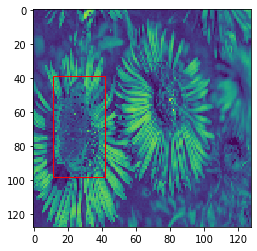

In [40]:
pic = val[1][0].unsqueeze(0)
show_data(val[1][0], val[1][1], val[1][2], box[0], train=True)

In [41]:
conv_layers=[]
model_children=list(cnn.children())

for child in model_children:
  if type(child)== torch.nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)== torch.nn.Sequential:
    for layer in child.children():
      if type(layer)== torch.nn.Conv2d:
        conv_layers.append(layer)
print(len(conv_layers))

5


In [42]:

results = [conv_layers[0](pic)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
out = results

Layer  1


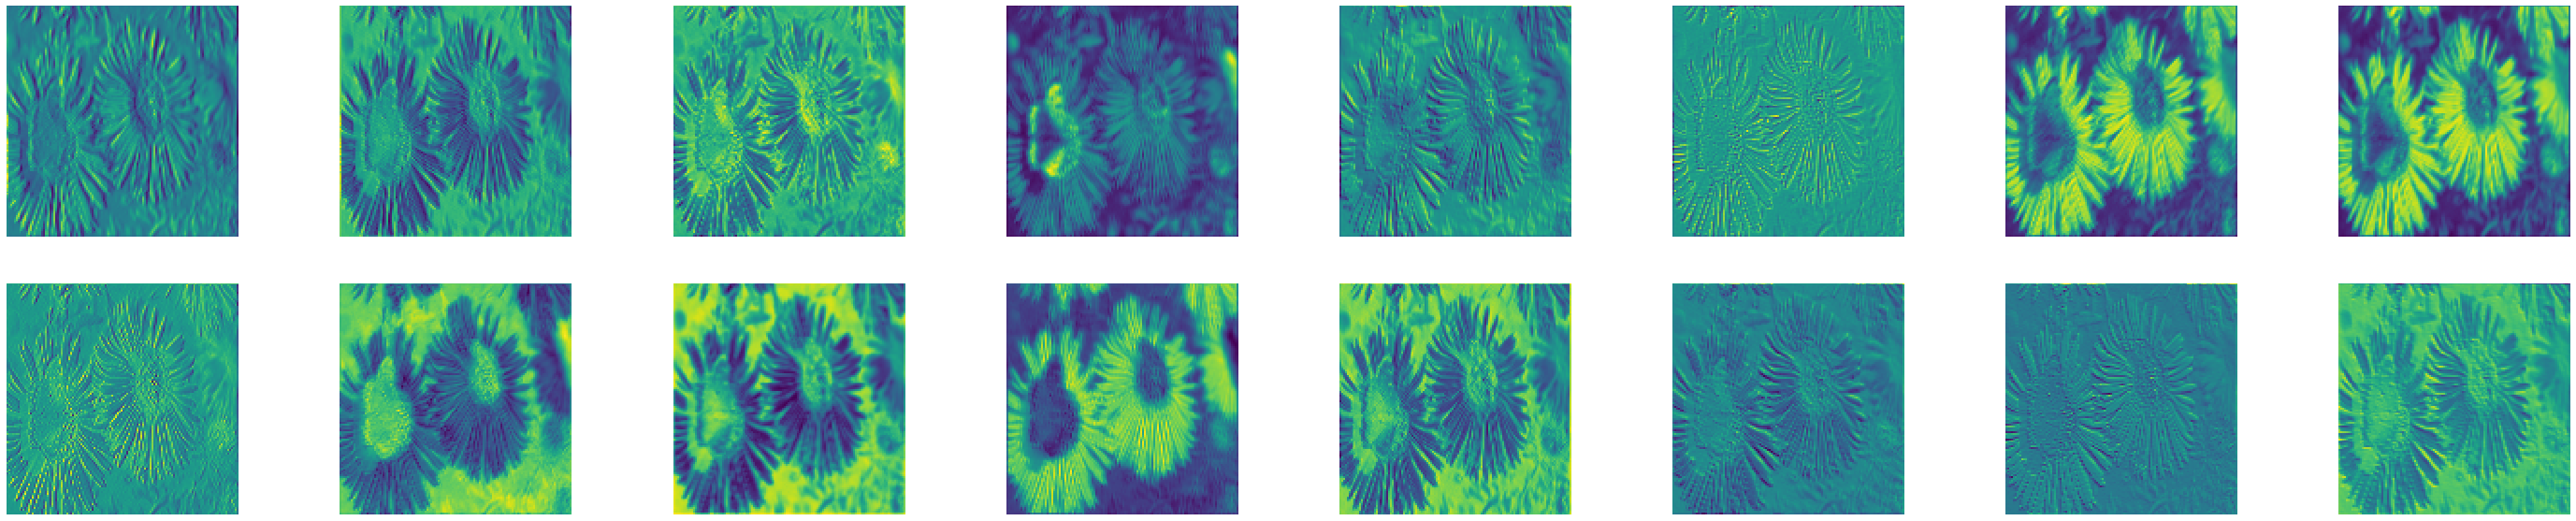

Layer  2


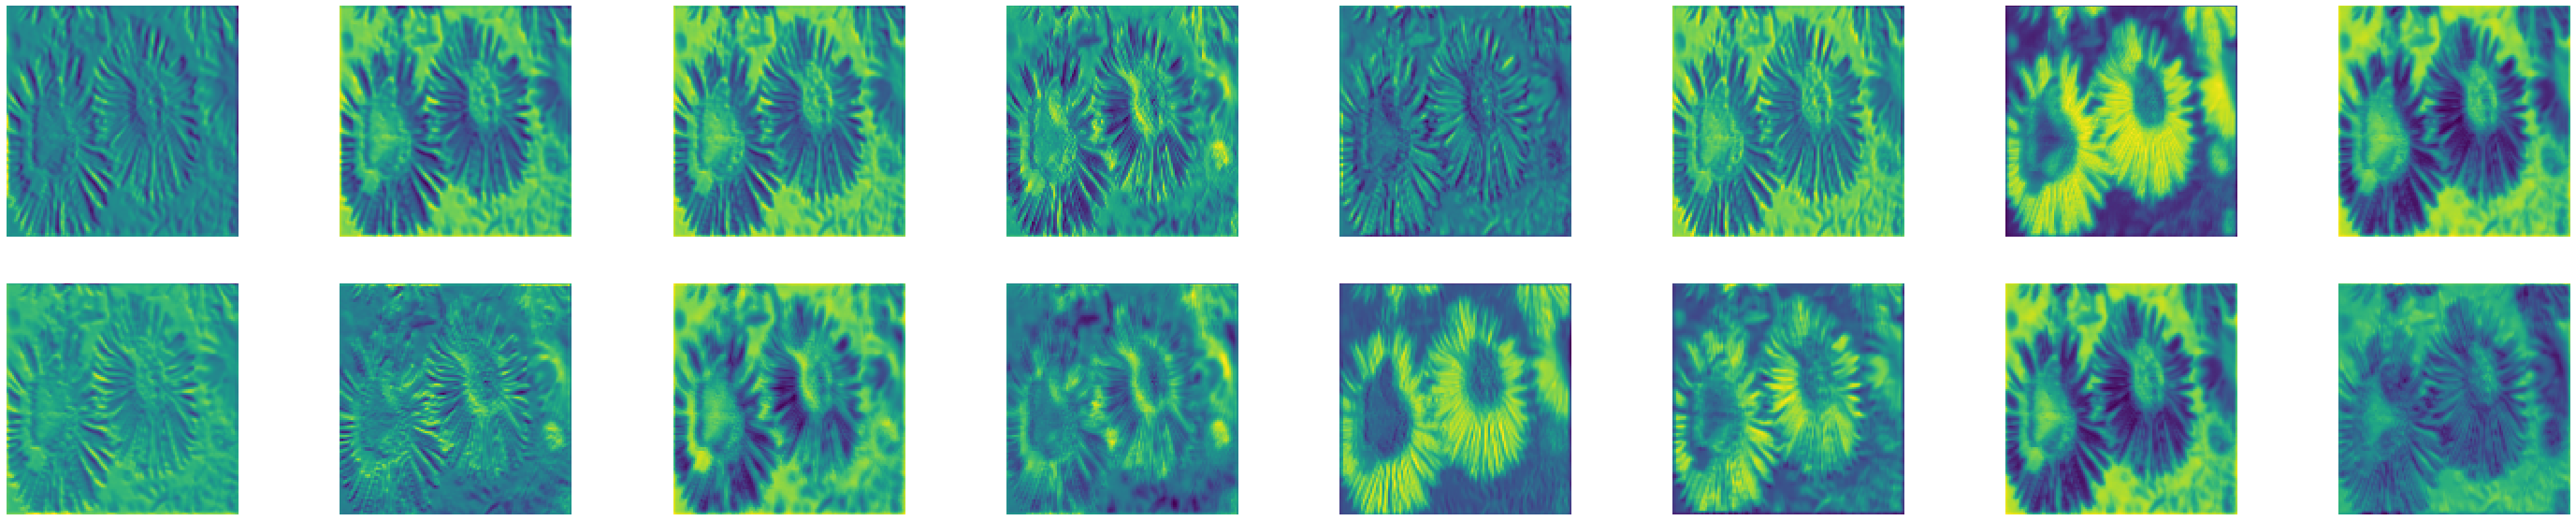

Layer  3


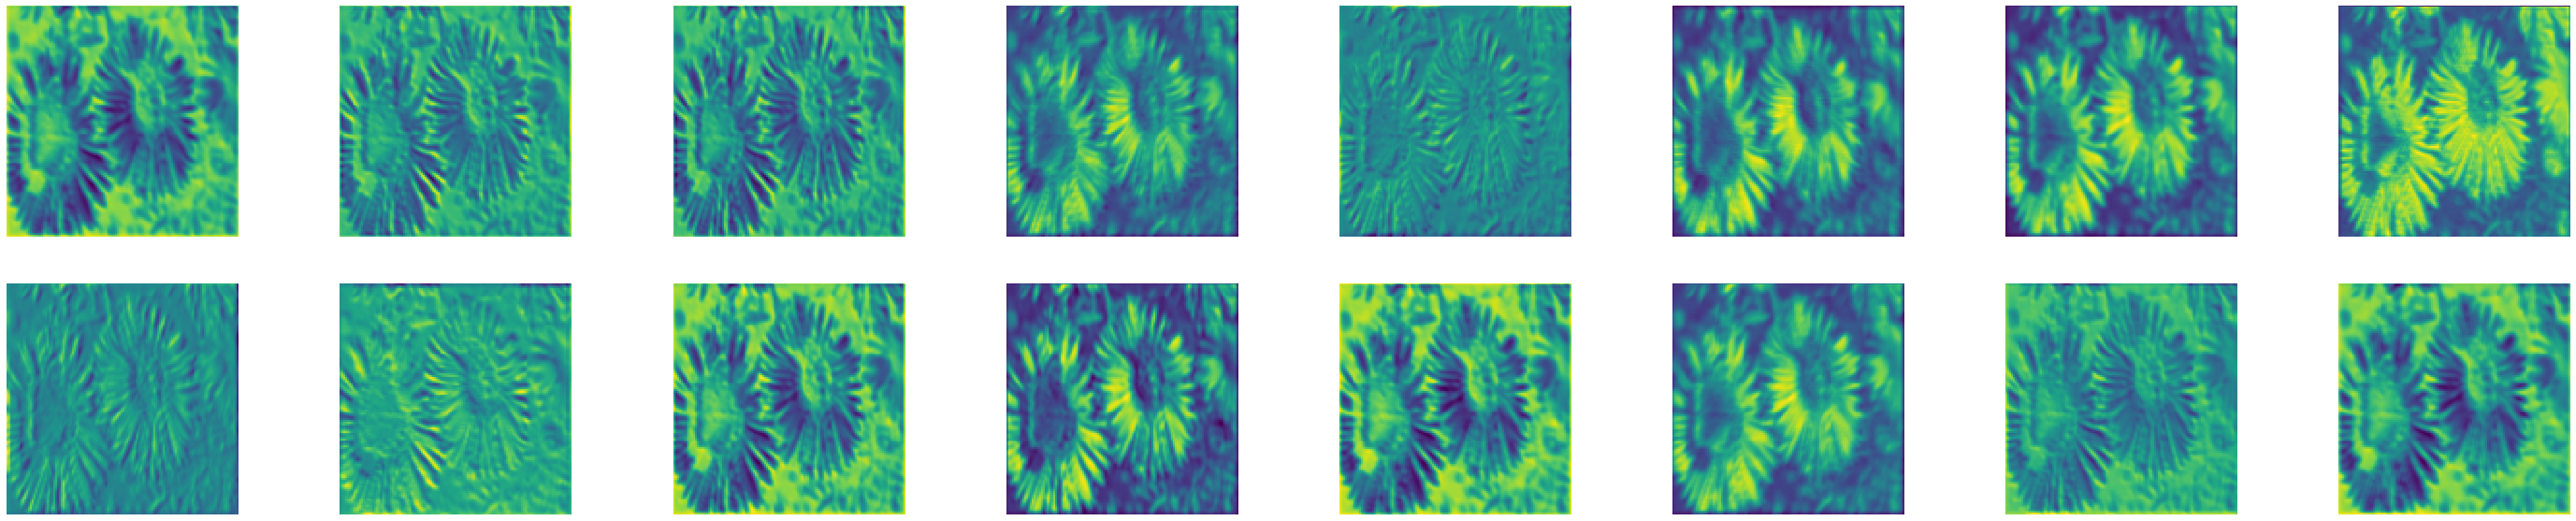

Layer  4


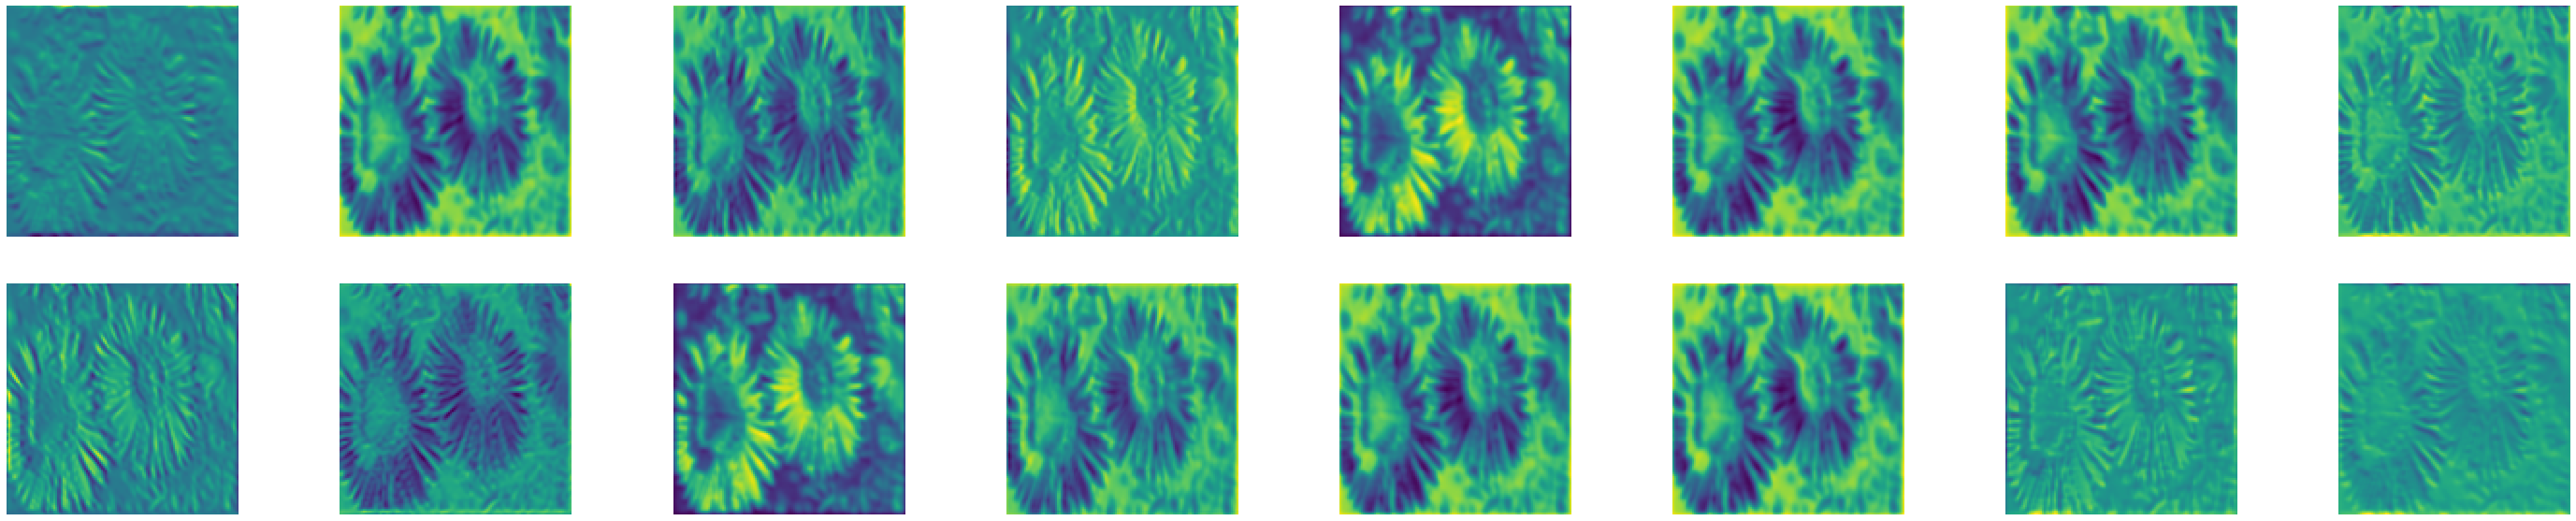

Layer  5


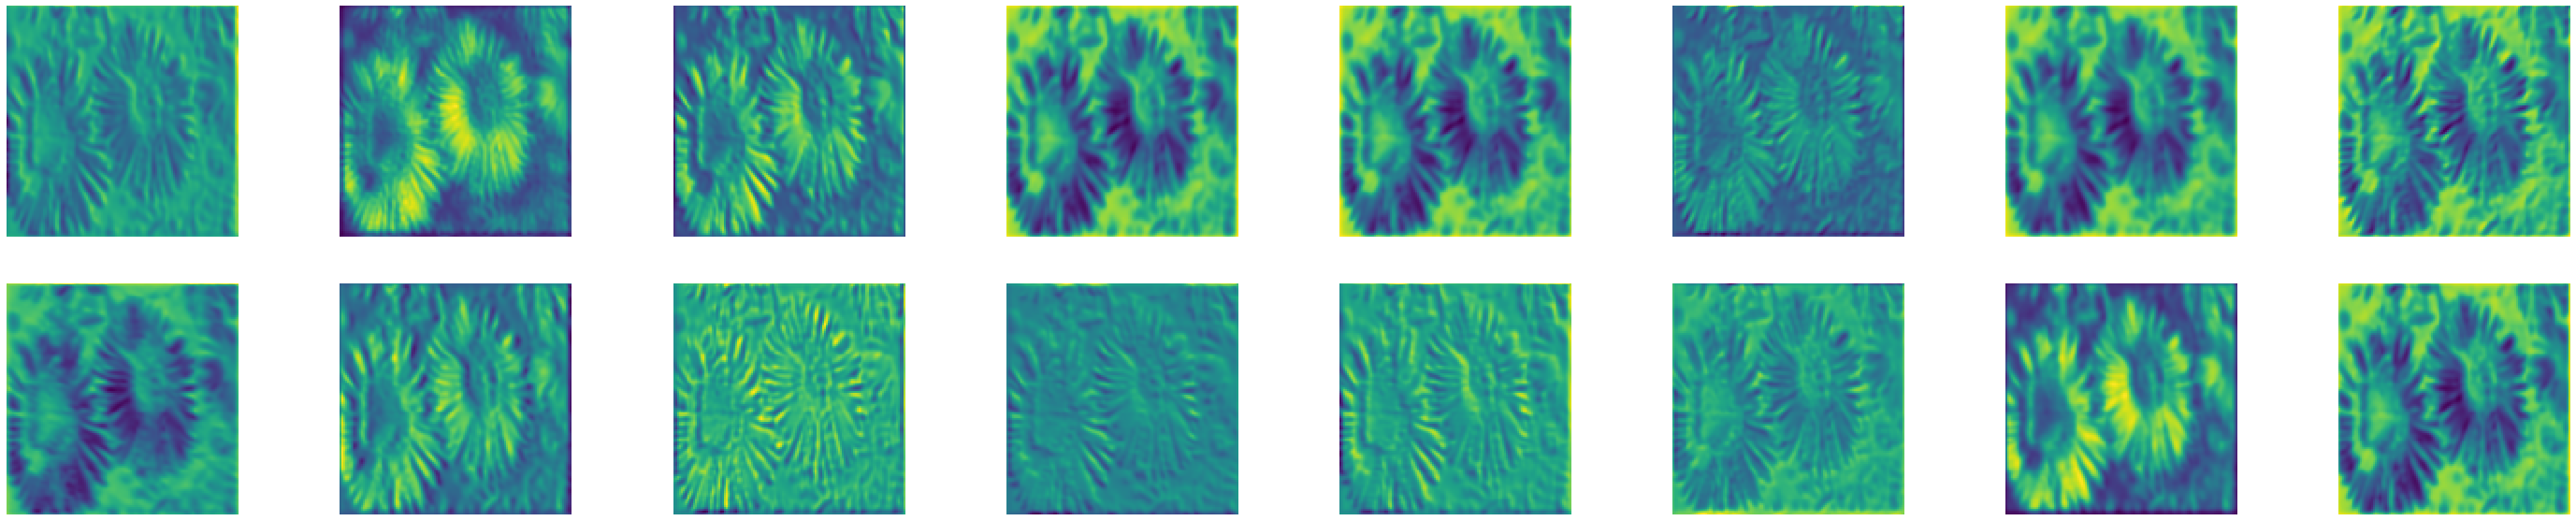

In [43]:
for num_layer in range(len(out)):
    plt.figure(figsize=(50, 10))
    layer_viz = out[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter)
        plt.axis("off")
    plt.show()
    plt.close()

# Plotting the results 

In [44]:
pic = val[1][0].unsqueeze(0).to(device) #one picture
pic.shape

torch.Size([1, 3, 128, 128])

In [45]:
pic.requires_grad_() #here I configure, need gradients to pic

tensor([[[[0.1725, 0.1529, 0.1216,  ..., 0.9216, 0.8824, 0.9176],
          [0.1529, 0.1333, 0.0824,  ..., 0.8824, 0.9255, 0.8863],
          [0.1176, 0.0824, 0.0549,  ..., 0.8039, 0.8745, 0.8941],
          ...,
          [0.0549, 0.0314, 0.0471,  ..., 0.1765, 0.0941, 0.1961],
          [0.0627, 0.0745, 0.0588,  ..., 0.2510, 0.1569, 0.1804],
          [0.0510, 0.0588, 0.0706,  ..., 0.2392, 0.2118, 0.1333]],

         [[0.1333, 0.1333, 0.1412,  ..., 0.6706, 0.6078, 0.6314],
          [0.1294, 0.1333, 0.1098,  ..., 0.6000, 0.6353, 0.5882],
          [0.1412, 0.1137, 0.0902,  ..., 0.4784, 0.5529, 0.5804],
          ...,
          [0.1176, 0.0980, 0.1216,  ..., 0.2196, 0.1490, 0.2588],
          [0.1333, 0.1412, 0.1373,  ..., 0.3098, 0.2196, 0.2431],
          [0.1216, 0.1333, 0.1373,  ..., 0.3059, 0.2745, 0.1961]],

         [[0.2000, 0.1922, 0.1765,  ..., 0.9059, 0.8471, 0.8745],
          [0.1961, 0.1882, 0.1451,  ..., 0.8745, 0.8941, 0.8392],
          [0.1922, 0.1647, 0.1255,  ..., 0

In [46]:
label, box = cnn(pic)

Saliency map

In [47]:
label_indx = label.argmax()
out_max = label[0,label_indx]
out_max.backward()

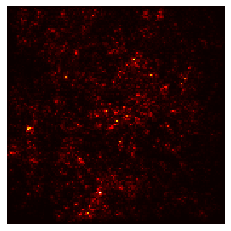

In [48]:
saliency, _ = torch.max(pic.grad.data.abs(), dim=1) 

plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()

In [49]:
label

tensor([[-0.0576,  0.0440,  0.2405, -0.2709,  0.0949,  0.5823, -0.4653]],
       grad_fn=<AddmmBackward0>)

In [50]:
box = box.tolist()

In [51]:
box

[[47.90997314453125, 41.24187088012695, 32.02286148071289, 40.387542724609375]]

True box: tensor([11, 39, 31, 59], dtype=torch.int32)
Predicted box: [47.90997314453125, 41.24187088012695, 32.02286148071289, 40.387542724609375]
tensor(5)


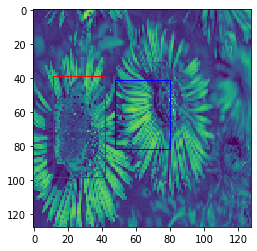

In [52]:
show_data(val[1][0], val[1][1], val[1][2], box[0], train=False)

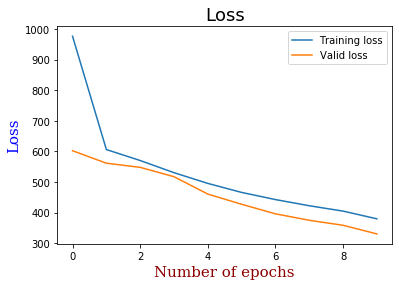

In [53]:
plt.plot(H['total_train_loss'], label= 'Training loss')
plt.plot(H['total_val_loss'], label= 'Valid loss')
plt.title("Loss", fontdict = {'size':18})
plt.xlabel('Number of epochs', fontdict = {'family':'serif','color':'darkred','size':15})
plt.ylabel('Loss', fontdict = {'family':'serif','color':'blue','size':15})
plt.legend()
plt.show()

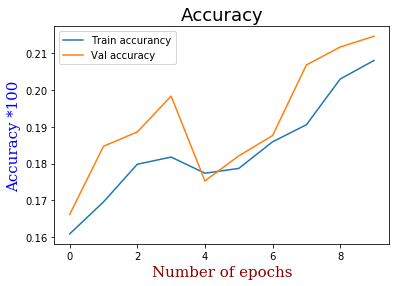

In [54]:
plt.plot(H['train_class_acc'], label = 'Train accurancy')
plt.plot(H['val_class_acc'], label = 'Val accuracy')
plt.title("Accuracy", fontdict = {'size':18})
plt.xlabel('Number of epochs', fontdict = {'family':'serif','color':'darkred','size':15})
plt.ylabel('Accuracy *100', fontdict = {'family':'serif','color':'blue','size':15})
plt.legend()
plt.show()

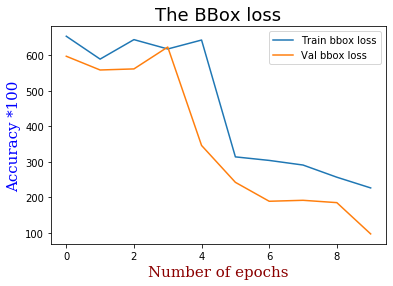

In [55]:
plt.plot(H["bbox_train_loss"], label = 'Train bbox loss')
plt.plot(H["bbox_val_loss"], label = 'Val bbox loss')
plt.title("The BBox loss", fontdict = {'size':18})
plt.xlabel('Number of epochs', fontdict = {'family':'serif','color':'darkred','size':15})
plt.ylabel('Accuracy *100', fontdict = {'family':'serif','color':'blue','size':15})
plt.legend()
plt.show()

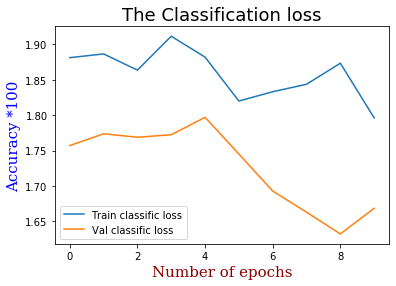

In [56]:
plt.plot(H['class_train_loss'], label = 'Train classific loss')
plt.plot(H['class_val_loss'], label = 'Val classific loss')
plt.title("The Classification loss", fontdict = {'size':18})
plt.xlabel('Number of epochs', fontdict = {'family':'serif','color':'darkred','size':15})
plt.ylabel('Accuracy *100', fontdict = {'family':'serif','color':'blue','size':15})
plt.legend()
plt.show()